In [1]:
#inportovanie potrebnych kniznic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
import json
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import pearsonr, spearmanr
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/danielap/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/danielap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/danielap/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Načítanie potrebného datasetu

In [2]:
data = []

with open('../datasety/pred_ocistenim_dataset.json', 'r') as file:
    for line in file:
        try:
            # Každý riadok je samostatný JSON objekt, nie zoznam.
            json_obj = json.loads(line)
            data.append(json_obj)
        except json.JSONDecodeError as e:
            print(f"Chyba pri dekódovaní JSON na riadku: {e}")

Dali sme to do formátu dataframe, až s tým viem dobre pracovať

In [3]:
analysis = pd.DataFrame(data)
analysis.head()

,text,id,occupation,gender,fame,birthyear
0,[I'm back! I'll be live on stage with @RTRSPod...,6450,sports,male,star,1994
1,[My buddy kerryrhodes produced this awesome mo...,1199,performer,male,star,1986
2,"[@MandiMoss I felt that way about 5!, @danasca...",21419,performer,female,star,1976
3,"[@frankwkelly @rte Cheers Frank!, @AnthonyShan...",17446,creator,female,superstar,1979
4,[RT @Protect_Wldlife: Watching this makes me s...,20448,sports,male,star,1986


In [4]:
analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        10144 non-null  object
 1   id          10144 non-null  int64 
 2   occupation  10144 non-null  object
 3   gender      10144 non-null  object
 4   fame        10144 non-null  object
 5   birthyear   10144 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 475.6+ KB


In [5]:
analysis['occupation'].unique()

array(['sports', 'performer', 'creator', 'manager', 'politics',
       'religious', 'science', 'professional'], dtype=object)

In [6]:
analysis['fame'].unique()

array(['star', 'superstar', 'rising'], dtype=object)

In [7]:
analysis.describe()

,id,birthyear
count,10144.000000,10144.000000
mean,24305.750493,1977.239255
std,13979.338296,13.592339
min,2.000000,1940.000000
25%,12242.500000,1968.000000
50%,24291.000000,1980.000000
75%,36543.250000,1988.000000
max,48328.000000,2005.000000


## Analýza datasetu

V našej analýze sme sa sústredili primárne na vek a poklavie, kedže to sú predmety nášho skúmania v bakalárke. Dali by sa dalšie veci analyzovať ako napríklad sláva v tomto datasete, však nemalo by to žiadnu pridanú hodnotu, kedže tieto slpce neskôr vymazujem a nikde ich nepoužívam

Zistili sme si počet mužov a žien

In [8]:
gender_counts = analysis['gender'].value_counts()

print("Počet ľudí v datasete podľa pohlavia:")
print(gender_counts)

Počet ľudí v datasete podľa pohlavia:
male      7169
female    2975
Name: gender, dtype: int64


Pre lepšiu predstavu sme to vizuovali

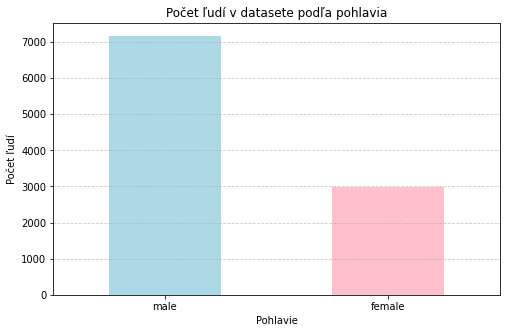

In [9]:
plt.figure(figsize=[8,5])
gender_counts.plot(kind='bar', color=['lightblue', 'pink'])
plt.title('Počet ľudí v datasete podľa pohlavia') 
plt.xlabel('Pohlavie') 
plt.ylabel('Počet ľudí') 
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

Na grafe môžeme vidieť, že je omnoho menej žien v datasete ako mužov

Určili sme si vekové skupiny a zistilipočet ľudí v nich

In [10]:
#zistenie veku
current_year = datetime.now().year
analysis['age'] = current_year - analysis['birthyear']
#zaradenie do vekovej kategorie
bins = [0, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
analysis['age_group'] = pd.cut(analysis['age'], bins=bins, labels=labels, right=False)
#zistenie poctu zaznamov pre každu kategoriu
age_group_counts = analysis['age_group'].value_counts().sort_index()

print("Počet ľudí v datasete podľa vekových skupín:")
print(age_group_counts)

Počet ľudí v datasete podľa vekových skupín:
0-29      571
30-39    3174
40-49    2601
50-59    1821
60-69    1172
70-79     676
80+       129
Name: age_group, dtype: int64


Pre lepšiu predstavu sme si to vizuovali v grafe

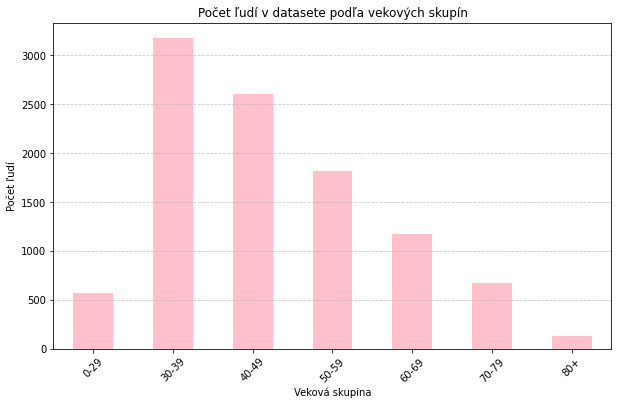

In [11]:
plt.figure(figsize=[10,6])
age_group_counts.plot(kind='bar', color='pink') 
plt.title('Počet ľudí v datasete podľa vekových skupín')
plt.xlabel('Veková skupina') 
plt.ylabel('Počet ľudí')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show() 

Ako môžeme vidieť na grafe, tak najviac ľudí je vo veku 30-39 rokov v mojom datasete

Následne sme si pozreli koľko mužov a žien je v jednotlivých vekových skupinách

In [12]:
gender_age_distribution = analysis.groupby(['gender', 'age_group']).size().unstack(fill_value=0)

print("Počet údajov podľa pohlavia a vekových skupín:")
print(gender_age_distribution)

Počet údajov podľa pohlavia a vekových skupín:
age_group  0-29  30-39  40-49  50-59  60-69  70-79  80+
gender                                                 
female      197    886    842    529    324    176   21
male        374   2288   1759   1292    848    500  108


Následne sme si to aj vizualizovali

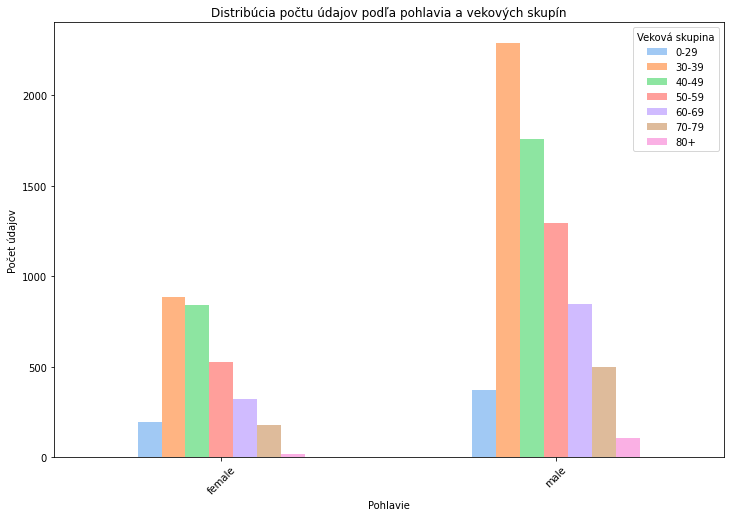

In [13]:
my_palette = sns.color_palette("pastel")
gender_age_distribution.plot(kind='bar', figsize=(12, 8), color=my_palette)

plt.title('Distribúcia počtu údajov podľa pohlavia a vekových skupín')
plt.xlabel('Pohlavie')
plt.ylabel('Počet údajov')
plt.legend(title='Veková skupina')
plt.xticks(rotation=45)
plt.show()

Na grafe vyššie môžeme vidieť, že najviac žien aj mužov je vo vekových kategóriách 30-39 a 40-49, ktoré sú najpočetnejšie skupiny v datasete; toto zistenie je relatívne očakávané. Vzhľadom na to, že mužov je viac, sú výraznejšie zastúpení vo všetkých vekových kategóriách. Preto sme sa rozhodli znormalizovať vekové kategórie, aby sme eliminovali vplyv nerovnomernej distribúcie  na výsledky. Z normalizovaného grafu nižšie je zrejmé, že muži sú viac zastúpení v starších vekových kategóriách a v kategórii 30-39, zatiaľ čo ženy prevládajú v mladších vekových skupinách s výnimkou kategórie 30-39.

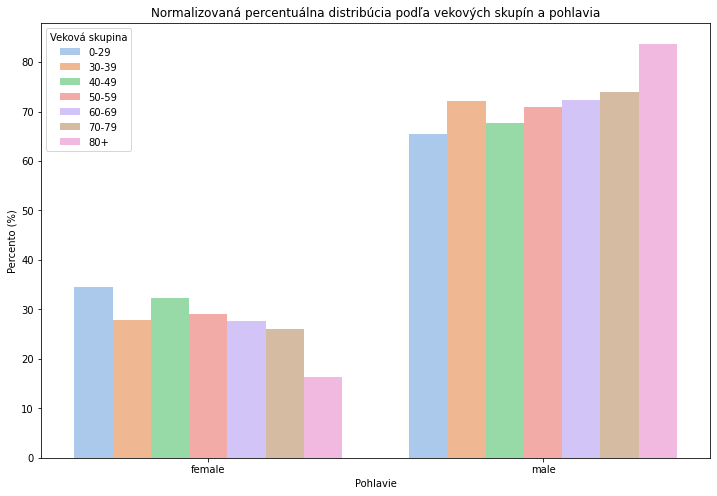

In [14]:
# Najprv spočítame počet záznamov podľa pohlavia a vekovej skupiny
gender_age_distribution = analysis.groupby(['gender', 'age_group']).size().unstack(fill_value=0)

# Zistíme celkové počty pre každú vekovú skupinu v celom datasete
total_per_age_group = analysis.groupby('age_group').size()

# Normalizujeme údaje podľa celkového počtu v každej vekovej skupine
normalized_distribution = gender_age_distribution.div(total_per_age_group, axis=1) * 100

# Konvertujeme kategorické typy na string, aby sa predišlo problémom s kategorickým indexom
normalized_distribution.columns = normalized_distribution.columns.astype(str)
normalized_distribution = normalized_distribution.reset_index()

# Pripravíme údaje pre vizualizáciu
data = pd.melt(normalized_distribution, id_vars='gender', value_vars=normalized_distribution.columns[1:], var_name='age_group', value_name='percent')

# Vizualizácia normalizovaných údajov
plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='gender', y='percent', hue='age_group', palette='pastel')

plt.title('Normalizovaná percentuálna distribúcia podľa vekových skupín a pohlavia')
plt.ylabel('Percento (%)')
plt.xlabel('Pohlavie')
plt.legend(title='Veková skupina')
plt.xticks(rotation=0)
plt.show()


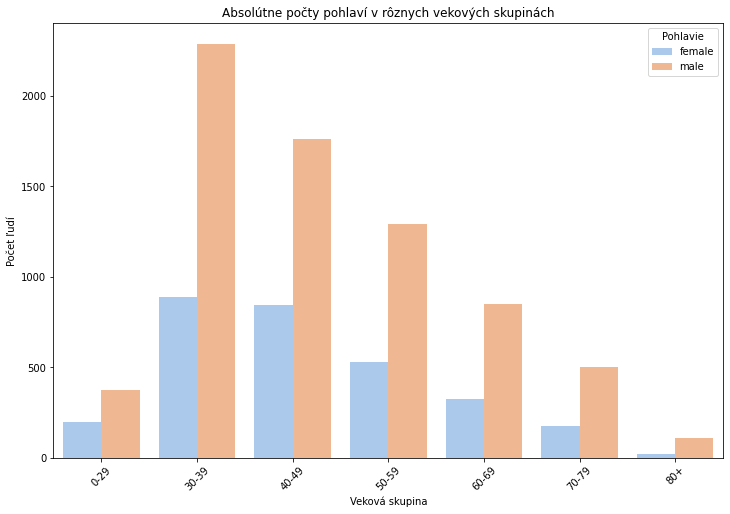

In [15]:
# Najprv spočítame počet záznamov podľa pohlavia a vekovej skupiny
gender_age_distribution = analysis.groupby(['gender', 'age_group']).size().unstack(fill_value=0)

# Pripravíme údaje pre vizualizáciu a preusporiadame dáta na potrebný formát
gender_age_distribution = gender_age_distribution.T.reset_index()
melted_data = pd.melt(gender_age_distribution, id_vars='age_group', value_vars=['female', 'male'], var_name='gender', value_name='count')

# Vizualizácia údajov
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_data, x='age_group', y='count', hue='gender', palette='pastel')
plt.title('Absolútne počty pohlaví v rôznych vekových skupinách')
plt.ylabel('Počet ľudí')
plt.xlabel('Veková skupina')
plt.legend(title='Pohlavie')
plt.xticks(rotation=45)
plt.show()

Na grafe môžeme vidieť, že vo všetkých vekových kategoriach prevládajú muži. Je to predpokladané, kedže mužu tvoria väčšiu časť datasetu. Preto sme si skúsili znormalizovať pohlavie, aby sme minimalizovali vply distribúcie na výsledok a aby sme lepšie videli početnosť pohlaví medzi vekovými kategoriami. Na grafe nižsie už môžeme vidieť, že rozdieli medzi pohlaviami nie sú až tak značné, v niektorých kategoriach prevládajú muži, v niektorých ženy.

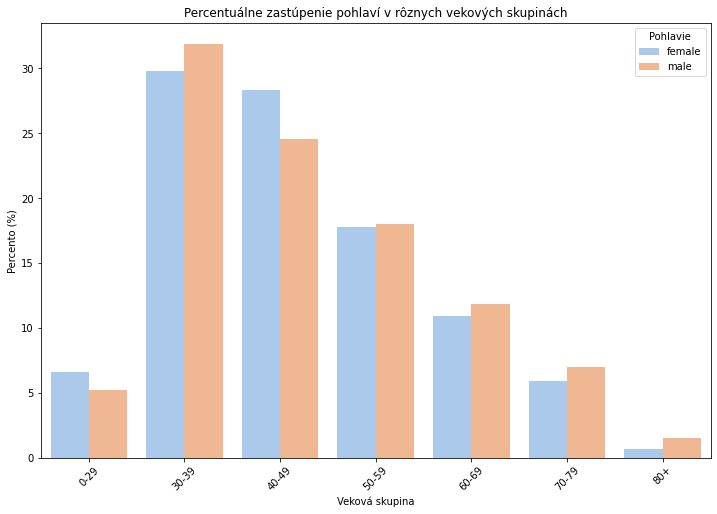

In [16]:
# Najprv spočítame počet záznamov podľa pohlavia a vekovej skupiny
gender_age_distribution = analysis.groupby(['gender', 'age_group']).size().unstack(fill_value=0)

# Zistíme celkové počty pre každé pohlavie
total_per_gender = gender_age_distribution.sum(axis=1)

# Normalizujeme údaje podľa celkového počtu mužov a žien
normalized_distribution = gender_age_distribution.div(total_per_gender, axis=0) * 100

# Pripravíme údaje pre vizualizáciu a preusporiadame dáta na potrebný formát
normalized_distribution = normalized_distribution.T.reset_index()
melted_data = pd.melt(normalized_distribution, id_vars='age_group', value_vars=['female', 'male'], var_name='gender', value_name='percent')

# Vizualizácia normalizovaných údajov
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_data, x='age_group', y='percent', hue='gender', palette='pastel')

plt.title('Percentuálne zastúpenie pohlaví v rôznych vekových skupinách')
plt.ylabel('Percento (%)')
plt.xlabel('Veková skupina')
plt.legend(title='Pohlavie')
plt.xticks(rotation=45)
plt.show()

Zistili sme priemerny, maximálny, minimálny a celkový počet príspevkov na osobu

In [17]:
analysis['post_count'] = analysis['text'].apply(lambda x: len(x) if isinstance(x, list) else len(x.split(',')))

average_posts_per_person = analysis['post_count'].mean()
print("Priemerný počet príspevkov na osobu:", average_posts_per_person)

min_posts_per_person = analysis['post_count'].min()
print("Minimálny počet príspevkov na osobu:", min_posts_per_person)

max_posts_per_person = analysis['post_count'].max()
print("Maximálny počet príspevkov na osobu:", max_posts_per_person)

total_posts = analysis['post_count'].sum()
print("Celkový počet príspevkov:", total_posts)

Priemerný počet príspevkov na osobu: 2193.945780757098
Minimálny počet príspevkov na osobu: 1
Maximálny počet príspevkov na osobu: 3000
Celkový počet príspevkov: 22255386


Vytvorili sme si kategorie počtu príspevkov a rozdelili si do nich ľudí

In [18]:
bins = [0, 301, 401, 501, 1000, 2000, 3000, 4000, float('inf')]
labels = ['0-300', '301-400', '401-500', '501-1000', '1001-2000', '2001-3000', '3001-4000', '4000 and more']
analysis['post_category'] = pd.cut(analysis['post_count'], bins=bins, labels=labels, right=False)

post_count_distribution = analysis['post_category'].value_counts().sort_index()

print("Rozdelenie počtu príspevkov podľa kategórií:")
print(post_count_distribution)

Rozdelenie počtu príspevkov podľa kategórií:
0-300             867
301-400           227
401-500           208
501-1000          885
1001-2000        1262
2001-3000        6292
3001-4000         403
4000 and more       0
Name: post_category, dtype: int64


Vizualizovali sme si to

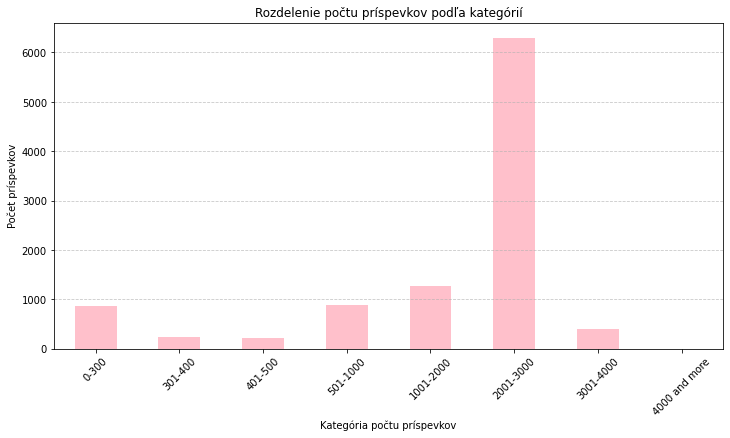

In [19]:
plt.figure(figsize=[12,6])
post_count_distribution.plot(kind='bar', color='pink')
plt.title('Rozdelenie počtu príspevkov podľa kategórií') 
plt.xlabel('Kategória počtu príspevkov') 
plt.ylabel('Počet príspevkov')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

Ako môžeme vidieť aj na grafe, tak ľudia majú 300-500 príspevkov

Pozreli som si počty príspevkov na základe pohlavia

In [20]:
post_gender_distribution = pd.crosstab(analysis['post_category'], analysis['gender'])

print("Rozdelenie počtu príspevkov podľa kategórií a pohlavia:")
print(post_gender_distribution)

Rozdelenie počtu príspevkov podľa kategórií a pohlavia:
gender         female  male
post_category              
0-300             162   705
301-400            41   186
401-500            45   163
501-1000          214   671
1001-2000         346   916
2001-3000        2066  4226
3001-4000         101   302


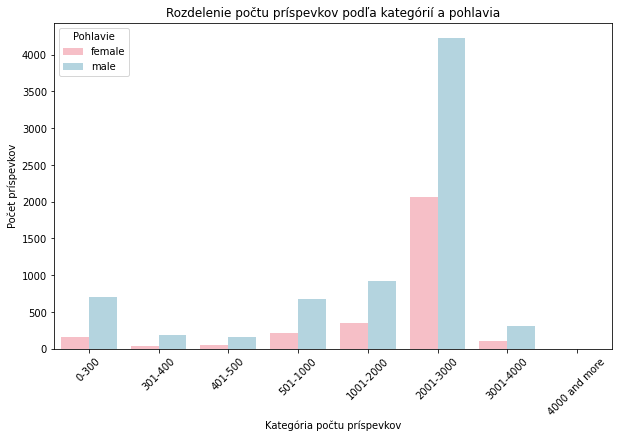

In [21]:
post_gender_distribution_wide = post_gender_distribution.reset_index().melt(id_vars='post_category', value_vars=['female', 'male'])

# Vytvorenie stĺpcového grafu
custom_palette = ["#ffb6c1","#add8e6"] 
plt.figure(figsize=(10, 6))
sns.barplot(x='post_category', y='value', hue='gender', data=post_gender_distribution_wide, palette=custom_palette)

plt.title('Rozdelenie počtu príspevkov podľa kategórií a pohlavia')
plt.xlabel('Kategória počtu príspevkov')
plt.ylabel('Počet príspevkov')
plt.legend(title='Pohlavie')
plt.xticks(rotation=45)
plt.show()

Ako môžeme vidieť na grafe vyššie, tak vo všetkých kategoriach bolo viac mužov, čo je očakávané, kedže v datasete prevažujú muži. Preto sme sa to rozhodli zobraziť aj percenntuálne, aby sme videla naozajsté zastúpenie pohlaví v kategoriach bez ohľadu na ich množstvo v datasete. Predelili sme si počty pohlaví v jednotlivých kategoriach počtom celkového počtu daného pohlavia v datasete. Ako môžete vidieť na grafe nižšie, tak rozdieli medzi pohlaviami v jednotlivých kategoriach sa zmenšili. Stále vo väčšine kategorií je viac mužov, však v najviac zastúpenej kategorií 2001-3000 prevažujú ženy.

gender         female  male  female_percentage  male_percentage
post_category                                                  
0-300             162   705           5.445378         9.834008
301-400            41   186           1.378151         2.594504
401-500            45   163           1.512605         2.273678
501-1000          214   671           7.193277         9.359743
1001-2000         346   916          11.630252        12.777235
2001-3000        2066  4226          69.445378        58.948249
3001-4000         101   302           3.394958         4.212582


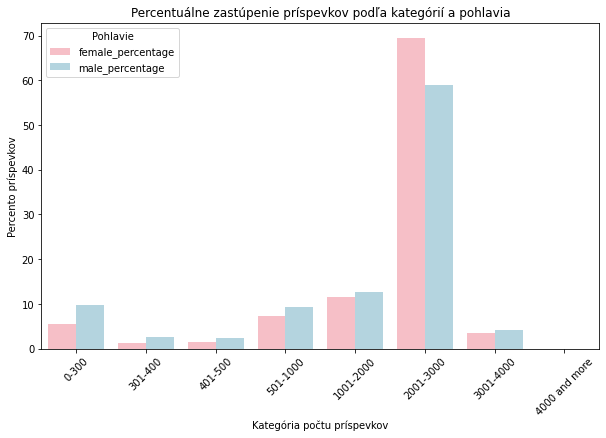

In [22]:
# Vypočítame percentuálne zastúpenie
post_gender_distribution['female_percentage'] = (post_gender_distribution['female'] / gender_counts['female']) * 100
post_gender_distribution['male_percentage'] = (post_gender_distribution['male'] / gender_counts['male']) * 100
print(post_gender_distribution)

# Pretransformujeme dáta pre vizualizáciu
post_gender_distribution.reset_index(inplace=True)
post_gender_distribution_wide2 = post_gender_distribution.melt(id_vars='post_category', value_vars=['female_percentage', 'male_percentage'], var_name='gender', value_name='percentage')

# Vytvorte graf
plt.figure(figsize=(10, 6))
sns.barplot(x='post_category', y='percentage', hue='gender', data=post_gender_distribution_wide2, palette=custom_palette )
plt.title('Percentuálne zastúpenie príspevkov podľa kategórií a pohlavia')
plt.xlabel('Kategória počtu príspevkov')
plt.ylabel('Percento príspevkov')
plt.legend(title='Pohlavie')
plt.xticks(rotation=45)
plt.show()

Pozreli sme si počty príspevkov na základe vekovej skupiny

In [23]:
#vytvorenie tabulky
post_age_distribution = pd.crosstab(analysis['post_category'], analysis['age_group'])

print("Rozdelenie počtu príspevkov podľa kategórií a vekových skupín:")
print(post_age_distribution)

Rozdelenie počtu príspevkov podľa kategórií a vekových skupín:
age_group      0-29  30-39  40-49  50-59  60-69  70-79  80+
post_category                                              
0-300           111    339    163    104     80     58   12
301-400          15    101     41     21     29     18    2
401-500          19     89     39     24     18     16    3
501-1000         68    361    179    109     88     66   14
1001-2000        81    489    271    181    121    106   13
2001-3000       269   1751   1807   1279    750    362   74
3001-4000         8     44    101    103     86     50   11


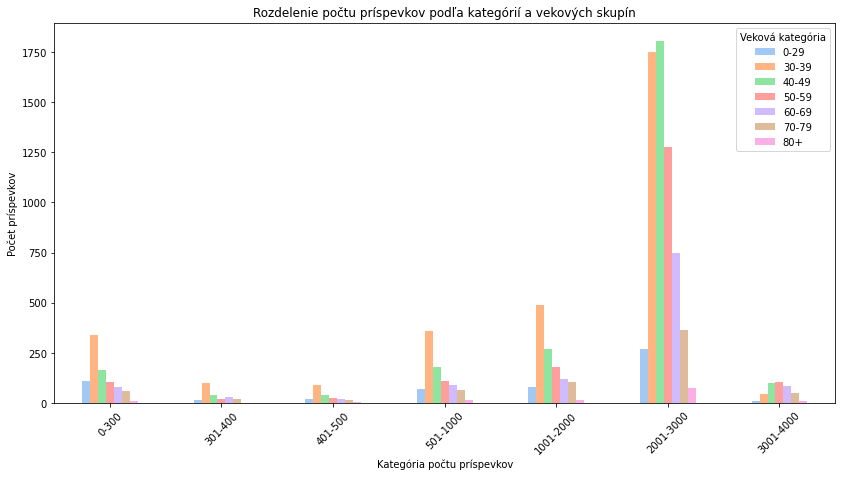

In [24]:
my_palette = sns.color_palette("pastel")
post_age_distribution.plot(kind='bar', figsize=(14, 7), color=my_palette)
plt.title('Rozdelenie počtu príspevkov podľa kategórií a vekových skupín')
plt.xlabel('Kategória počtu príspevkov')
plt.ylabel('Počet príspevkov')
plt.xticks(rotation=45)
plt.legend(title='Veková kategória')
plt.show()

Ako môžeme vidieť na grafe vyššie, tak najviac prevládza veková kategoria 30-39, čo má najväčie zastúpenie v datasete a za ňou hned veková skupina 40-49, čo má druhé najväčšie zastúpenie v datasete. Toto je niečo, čo očakávame, kedže vekové kategorie nie sú rovnomerne zástúpené. Preto sme znova sa rozhodli pre percentuálne zobrazenie aj v tomto prípade. Ako môžeme vidieť na grafe pod tymto textom, tak rozdiely medzi vekovými kategoriami sa značne zmenšili. Menej príspevkov majú mladšie alebo staršie vekové kategorie. Však v strednej vekovej kategorií majú ľudia väčšinou 2001-3000 príspevkov, čo je aj naša najpočetnejšia kategoria. Najviac príspevkov (3001-4000) majú najstaršie vekové kategorie.

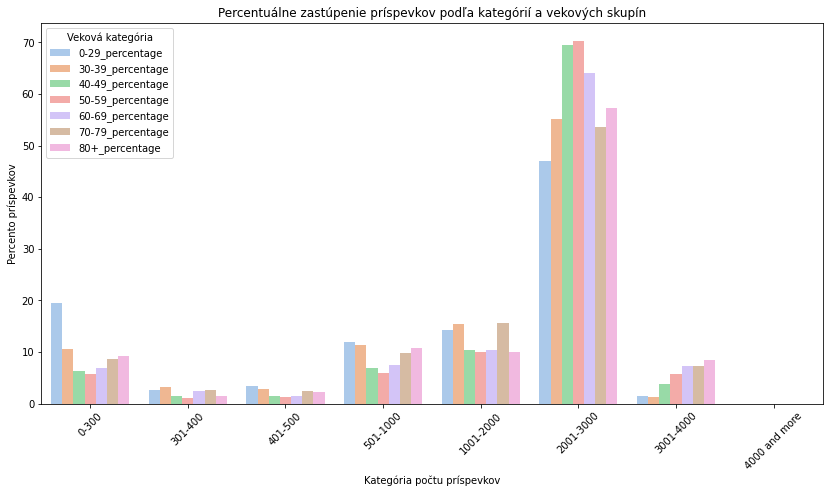

In [25]:
post_age_distribution.columns = post_age_distribution.columns.astype(str) 

for column in post_age_distribution.columns:
    # Vytvoríme nový stĺpec pre každú vekovú skupinu
    age_group = column.split('_')[0]  # Oddelíme názov vekovej skupiny
    if age_group in age_group_counts.index:
        total_count = age_group_counts[age_group]
        post_age_distribution[column + '_percentage'] = (post_age_distribution[column] / total_count) * 100

# Preformátovanie dát pre vizualizáciu
post_age_distribution2 = post_age_distribution.reset_index().melt(id_vars='post_category', value_vars=[col for col in post_age_distribution.columns if 'percentage' in col], var_name='age_group', value_name='percentage')

pastel_palette = sns.color_palette("pastel")
# Vytvorte graf
plt.figure(figsize=(14, 7))
sns.barplot(x='post_category', y='percentage', hue='age_group', data=post_age_distribution2, palette=pastel_palette)
plt.title('Percentuálne zastúpenie príspevkov podľa kategórií a vekových skupín')
plt.xlabel('Kategória počtu príspevkov')
plt.ylabel('Percento príspevkov')
plt.legend(title='Veková kategória')
plt.xticks(rotation=45)
plt.show()

V záznamoch s počtom príspevkov 301-400 dominuje veková kategoria 30-39 a v záznamoch s počtom príspevkov 401-500 dominuje veková kategoria 40-49

Zistili sme, či sa v datasete nachádzajú duplicitné záznamy

In [26]:
dataset = pd.DataFrame(analysis)
duplicates = dataset[dataset.duplicated(subset='id', keep=False)]
print(duplicates)

Empty DataFrame
Columns: [text, id, occupation, gender, fame, birthyear, age, age_group, post_count, post_category]
Index: []


V datasete sa nenachádzajú duplicitné záznamy

Následne sme manuálne prechádzali dataset až zistíme, či sa v datasete nachádzajú nežiadúce veci. Našli sme množstvo retweetov a tweetov v inom ako anglickom jazyku. O tieto veci sa postarame pri čistení datasetu. Našli sme však aj hashtagy, url adresy, označenia, unicode značky, nove riadky a tabulátory a podobne. Niektoré z týchto vecí sa nám zídu pri extrakcií črt, však treba si na ne dávať pozor a ked je to vhodné, ich odfiltrovať. 